# Transfer learning in kernels with PyTorch

Following the same strategy from Beluga's kernel [Use pretrained Keras models](https://www.kaggle.com/gaborfodor/use-pretrained-keras-models-lb-0-3), this kernel uses a dataset with PyTorch pretrained networks weights. 

Training in the CPU is quite slow, but it is still feasible to use a pre-trained network, replace the final layer and train just this last layer. 

Thanks Beluga for your great kernel. This one uses not only the concept but also a lot of the code. 

In [46]:
%matplotlib inline
import time
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets, models

In [47]:
np.random.seed(0)

This [dataset](https://www.kaggle.com/pvlima/pretrained-pytorch-models) has the PyTorch weights for some pre-trained networks.

We have to copy the pretrained models to the cache directory (~/.torch/models) where PyTorch is looking for them.

In [48]:
!ls ../input/pretrained-pytorch-models/ -lah

total 367M
drwxr-xr-x 2 nobody nogroup 4.0K Jan  8 05:52 .
drwxr-xr-x 5 root   root    4.0K Jun 19 04:29 ..
-rw-r--r-- 1 nobody nogroup 111M Jan  8 05:52 densenet161-17b70270.pth
-rw-r--r-- 1 nobody nogroup 104M Jan  8 05:52 inception_v3_google-1a9a5a14.pth
-rw-r--r-- 1 nobody nogroup  45M Jan  8 05:52 resnet18-5c106cde.pth
-rw-r--r-- 1 nobody nogroup  98M Jan  8 05:52 resnet50-19c8e357.pth
-rw-r--r-- 1 nobody nogroup 4.8M Jan  8 05:52 squeezenet1_0-a815701f.pth
-rw-r--r-- 1 nobody nogroup 4.8M Jan  8 05:52 squeezenet1_1-f364aa15.pth


In [49]:
cache_dir = expanduser(join('~', '.torch'))
if not exists(cache_dir):
    makedirs(cache_dir)
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    makedirs(models_dir)

In [50]:
!cp ../input/pretrained-pytorch-models/* ~/.torch/models/

In [51]:
!ls ~/.torch/models/

densenet161-17b70270.pth	  resnet50-19c8e357.pth
inception_v3_google-1a9a5a14.pth  squeezenet1_0-a815701f.pth
resnet18-5c106cde.pth		  squeezenet1_1-f364aa15.pth


In [52]:
!ls ../input/dog-breed-identification

labels.csv  sample_submission.csv  test  train


Using just 16 most frequent breeds to keep the running time under the kernel limit

In [53]:
INPUT_SIZE = 224
NUM_CLASSES = 16
data_dir = '../input/dog-breed-identification/'
labels = pd.read_csv(join(data_dir, 'labels.csv'))
sample_submission = pd.read_csv(join(data_dir, 'sample_submission.csv'))
print(len(listdir(join(data_dir, 'train'))), len(labels))
print(len(listdir(join(data_dir, 'test'))), len(sample_submission))

10222 10222
10357 10357


In [54]:
selected_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(NUM_CLASSES).index)
labels = labels[labels['breed'].isin(selected_breed_list)]
labels['target'] = 1
# labels['rank'] = labels.groupby('breed').rank()['id']
labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)

train = labels_pivot.sample(frac=0.8)
valid = labels_pivot[~labels_pivot['id'].isin(train['id'])]
print(train.shape, valid.shape)

(1422, 17) (355, 17)


In [55]:
# labels
# labels_pivot
train['afghan_hound']

942     0.0
1711    0.0
1688    0.0
795     0.0
581     0.0
       ... 
1144    0.0
1338    0.0
1037    0.0
1425    0.0
455     0.0
Name: afghan_hound, Length: 1422, dtype: float64

In [56]:
train.columns[1:][0]

'afghan_hound'

In [57]:
# labels.groupby('breed').rank()
selected_breed_list

['scottish_deerhound',
 'maltese_dog',
 'afghan_hound',
 'entlebucher',
 'bernese_mountain_dog',
 'shih-tzu',
 'great_pyrenees',
 'pomeranian',
 'basenji',
 'samoyed',
 'airedale',
 'tibetan_terrier',
 'leonberg',
 'cairn',
 'beagle',
 'japanese_spaniel']

In [58]:
class DogsDataset(Dataset):
    def __init__(self, labels, root_dir, subset=False, transform=None):
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img_name = '{}.jpg'.format(self.labels.iloc[idx, 0])
        fullname = join(self.root_dir, img_name)
        image = Image.open(fullname)
        labels = self.labels.iloc[idx, 1:]#.as_matrix().astype('float')
        labels = np.argmax(labels)
        if self.transform:
            image = self.transform(image)
        return [image, labels]

In [59]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
ds_trans = transforms.Compose([transforms.Scale(224),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               normalize])
train_ds = DogsDataset(train, data_dir+'train/', transform=ds_trans)
valid_ds = DogsDataset(valid, data_dir+'train/', transform=ds_trans)

train_dl = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_ds, batch_size=4, shuffle=True, num_workers=4)

/opt/conda/lib/python3.7/site-packages/torchvision/transforms/transforms.py:210: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [60]:
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow(inp)

torch.Size([4, 3, 224, 224]) torch.Size([4])


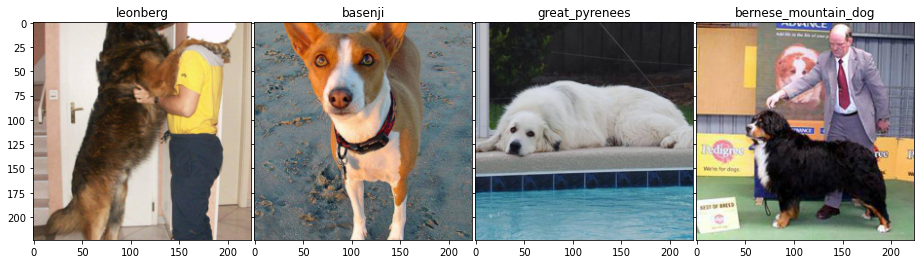

In [61]:
img, label = next(iter(train_dl))
print(img.size(), label.size())
fig = plt.figure(1, figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.05)    
for i in range(img.size()[0]):
    ax = grid[i]
    ax.set_title(train.columns[1:][label[i].item()])
    imshow(ax, img[i])

# ResNet50

### Just try the model 

In [62]:
!ls ~/.torch/models/resnet50-19c8e357.pth

/root/.torch/models/resnet50-19c8e357.pth


In [63]:
use_gpu = torch.cuda.is_available()
# resnet = models.resnet50(pretrained=False)
# resnet.load_state_dict(torch.load('/root/.torch/models/resnet50-19c8e357.pth'))
# resnet = torch.load('/root/.torch/models/resnet50-19c8e357.pth')
resnet = models.resnet18(pretrained=False)
# resnet.load_state_dict(torch.load('/root/.torch/models/resnet18-5c106cde.pth'))
resnet.load_state_dict(torch.load('../input/xxxxxxx/resnet18-5c106cde.pth'))

inputs, labels = next(iter(train_dl))
if use_gpu:
    resnet = resnet.cuda()
    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())   
else:
    inputs, labels = Variable(inputs), Variable(labels)
outputs = resnet(inputs)
outputs.size()

torch.Size([4, 1000])

The model seems to work OK. Resnet outputs probabilities for the imagenet 1000 labels as expected. 

### Replace last layer and train

Will replace the last layer with one that predicts the 16 classes. The network weights will be fixed expected for the last layer that is trained.

In [64]:
def train_model(dataloders, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    use_gpu = torch.cuda.is_available()
    best_model_wts = model.state_dict()
    best_acc = 0.0
    dataset_sizes = {'train': len(dataloders['train'].dataset), 
                     'valid': len(dataloders['valid'].dataset)}

    for epoch in range(num_epochs):
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloders[phase]:
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item() #.data[0]
#                 import pdb; pdb.set_trace()
                running_corrects += torch.sum(preds == labels.data)/1.
            
            if phase == 'train':
                train_epoch_loss = running_loss / dataset_sizes[phase]
                train_epoch_acc = running_corrects / dataset_sizes[phase]
            else:
                valid_epoch_loss = running_loss / dataset_sizes[phase]
                valid_epoch_acc = running_corrects / dataset_sizes[phase]
                
            if phase == 'valid' and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model_wts = model.state_dict()

        print('Epoch [{}/{}] train loss: {:.4f} acc: {:.4f} ' 
              'valid loss: {:.4f} acc: {:.4f}'.format(
                epoch, num_epochs - 1,
                train_epoch_loss, train_epoch_acc, 
                valid_epoch_loss, valid_epoch_acc))
            
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [65]:
# resnet = models.resnet50(pretrained=False)

# freeze all model parameters
for param in resnet.parameters():
    param.requires_grad = False

# new final layer with 16 classes
num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs, 16)
if use_gpu:
    resnet = resnet.cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

dloaders = {'train':train_dl, 'valid':valid_dl}

In [66]:
# pwd
# !ls ../input/xxxxxxx
torch.__version__

resnet18-5c106cde.pth


In [67]:
start_time = time.time()
model = train_model(dloaders, resnet, criterion, optimizer, exp_lr_scheduler, num_epochs=100)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

Epoch [0/99] train loss: 0.3744 acc: 0.5626 valid loss: 0.0966 acc: 0.8930
Epoch [1/99] train loss: 0.1939 acc: 0.7707 valid loss: 0.0701 acc: 0.9099


KeyboardInterrupt: 

In [22]:
def visualize_model(dataloders, model, num_images=16):
    cnt = 0
    fig = plt.figure(1, figsize=(16, 16))
    grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.05)
    for i, (inputs, labels) in enumerate(dataloders['valid']):
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            ax = grid[cnt]
            imshow(ax, inputs.cpu().data[j])
            ax.text(10, 210, '{}/{}'.format(preds[j], labels.data[j]), 
                    color='k', backgroundcolor='w', alpha=0.8)
            cnt += 1
            if cnt == num_images:
                return

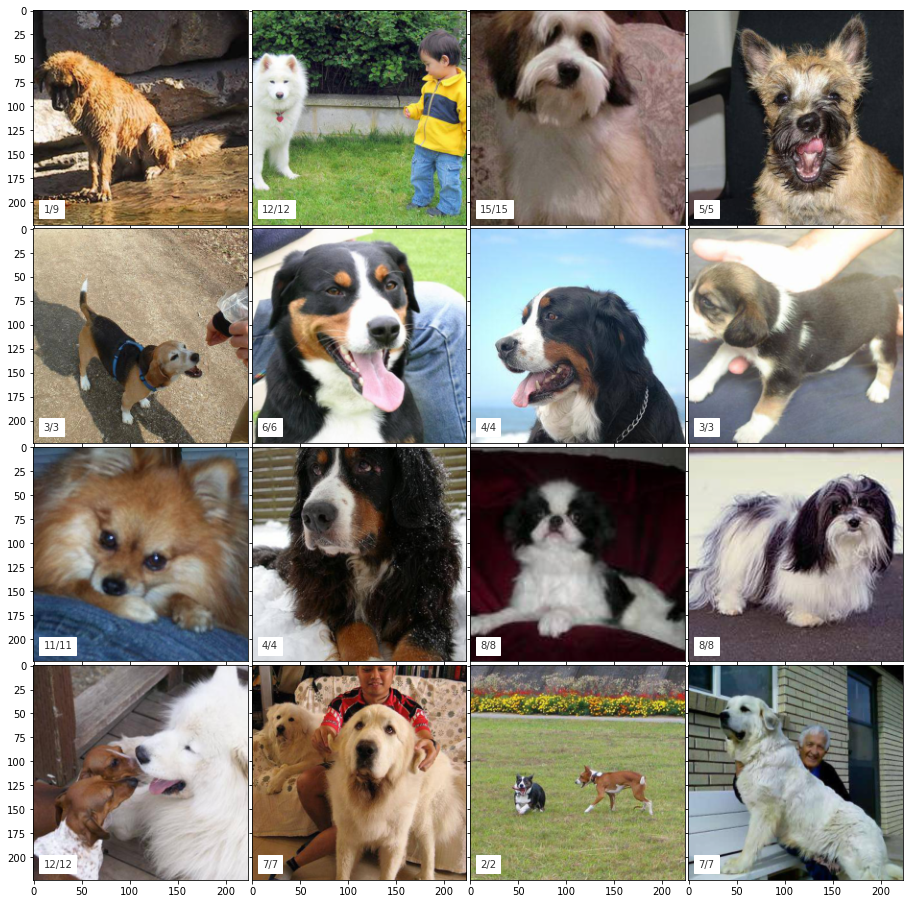

In [23]:
visualize_model(dloaders, resnet)

This kernel was mainly to test using transfer learning in kernels using PyTorch. Training is slow in CPU but it works.   